# The Shape of a Week

## Part I: problem statement

Some time ago, I was discussing some data analysis for the _Business Analytics_ project at the Illinois Geometry Lab with the other members of the team. We were predicting several business-relevant quantities using straightforward linear regression. One of the independent variables was the month in which certain transactions took place. The question we started discussing was simple: **how can we best encode this categorical variable for our regression?**

A standard approach to encoding categorical features is to use _one-hot encoding_, in which the $n$ categories are encoded using $n$ columns, and an observation where the categorical value takes the $i$'th value is encoded as a 1 in the $i$'th column (and zeroes elsewhere).
For example, January might be encoded as $(1,0,0,...,0)$, February as $(0,1,0,...,0)$, and so on, with December encoded as $(0,...,0,1)$.

A disadvantage of this method is that the number of dimensions increases a lot (namely by the number of categories). The question we can then ask is: **how can we best encode this categorical variable for our regression, if we limit ourselves to a given number of dimension?**

Suppose we restrict ourselves to a single dimension. One way one could encode months using one real number is as follows:

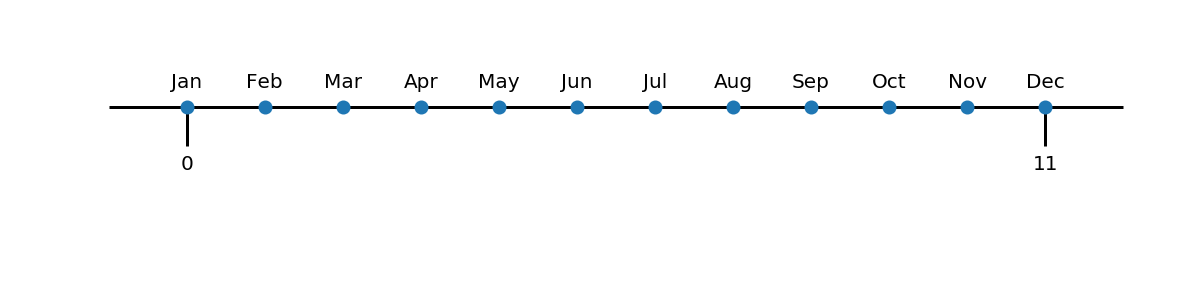

In [1]:
import matplotlib.pyplot as plt
plt.figure(1, figsize=(10,2))
plt.axis('off')
plt.axis('equal')
plt.hlines(0, -1, 12)
plt.vlines([0,11], -0.5, 0)
plt.scatter(range(12), [0 for i in range(12)], zorder=2)
for i, txt in enumerate(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']):
    plt.annotate(txt, (i, 0.2), horizontalalignment='center', verticalalignment='bottom')
plt.annotate('0', (0, -0.6), horizontalalignment='center', verticalalignment='top')
plt.annotate('11', (11, -0.6), horizontalalignment='center', verticalalignment='top')
plt.show()

This way of encoding months, though, is far from perfect. The biggest problem is that **December is far away from January** on this picture, even though they are close together in time. Suppose that you want to predict outdoor temperatures using the month as an independent variable. The warm months are those in the middle of the line segment, and the cold ones are at the ends (I'm writing this from the northern hemisphere). Linear regression will therefore perform very poorly for these predictions. For predicting temperature, it's best to put the warm months on one end of the line, and the cold months on the other. Of course, we only know this from our experience with seasons. In other situations, what would be a sensible way of encoding the categories to maximize regression effectiveness?

Let us find an **automated way of finding an encoding of a categorical feature**, in a way that makes **linear regression maximally effective** if we use this encoding.
In order to determine this encoding, we will use measurements from similar problems where the variable to be predicted is known.

Mathematically, we want to do the following.
Suppose that we have several datasets $D_1, ..., D_k$,
and that there is a categorical variable that shows up as a column in each of them. (We'll assume that there are no other categorical variables in them, or that they have been encoded as real numbers somehow.)
Suppose that there are $n$ different categories.
Given points $p_1, ..., p_n$ in $\mathbb{R}^m$, we can encode the categorical variable using $m$ columns,
and then perform linear regression on each of the datasets.
For each regression, we get an $R^2$-value that measures how much of the variance is explained by the regression.
**Find points $p_1, ..., p_n$ in $\mathbb{R}^m$ such that the sum of the $R^2$-values is maximal.**

In the example that we will study, the categorical variable is the weekday (so that there are seven categories), and we want to encode it using two dimensions. In non-mathematical phrasing, we are asking: **if you had to put seven points on a plane, each corresponding to a day of the week, what would be a sensible way of doing that?** What is the shape of a week?

A reasonable suggestion might be to put the points on a circle, like so:

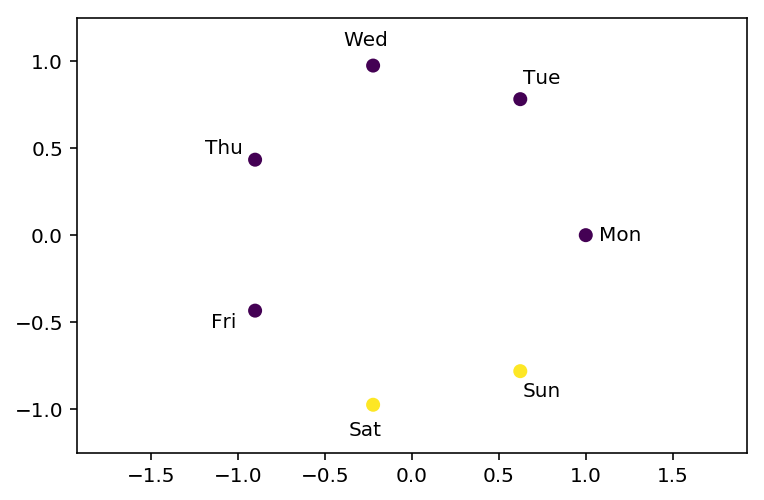

In [2]:
from math import sin, cos, pi
plt.axis('equal')
X = [cos(2*pi*i/7) for i in range(7)]
Y = [sin(2*pi*i/7) for i in range(7)]
plt.scatter(X, Y, c=[1,1,1,1,1,2,2])
plt.xlim(-1.5, 1.5)
plt.ylim(-1.25, 1.25)
for i, txt in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']):
    plt.annotate(txt, (1.2*X[i], 1.15*Y[i]), horizontalalignment='center', verticalalignment='center')
plt.show()

While this reflects the cyclic nature of a week well, it's probably not the best way to embed weekdays in a plane.
For example, for many purposes, the weekend is a special part of the week. It may therefore be natural to put Saturday and Sunday a little closer together, and farther away from the other days. Of course, the correct positioning heavily depends on the problem you're studying.

## Part II: principal component analysis

We will consider a special case of the above situation. This will make the calculations much more tractable.
The categorical variable is a weekday (so we have seven categories). Each of the datasets will be particularly simple: the categorical variable is the only variable, and each dataset has precisely seven observation, namely one in each category.
In this case, we can summarize the entire collection of $k$ datasets as a $(7\times k)$-matrix $Y$.
We will assume the columns of $Y_i$ are normalized to have mean 0 and variance 1.

Suppose we decide to embed the weekdays into the plane as $(x_1, y_1), ..., (x_7, y_7)$. We will put these coordinates into a matrix
$$ A = \begin{pmatrix} x_1 & y_1 \\ x_2 & y_2 \\ \vdots \\ x_7 & y_7 \end{pmatrix} .$$

Let us write $Y_i$ for the $i$'th column of $Y$ (i.e. the data of the $i$'th dataset). The sum of residuals when regressing this column on the weekdays is then
$$ \lVert Y_i - A(A^TA)^{-1}A^T Y_i \rVert^2 .$$
Summing over $i$, we want to minimize
$$ \sum_{i=1}^k \lVert Y_i - A(A^TA)^{-1}A^T Y_i \rVert^2 .$$

But we recognize this minimization problem from... principal component analysis!
The minimal total residuals are achieved when the columns of $A$ span the same plane in $\mathbb{R}^7$ as the first two axes of the hyperellipsoid determined by the points $Y_i \in \mathbb{R}^7$.

In other words, **the shape of a week that yields optimal regression can be calculated by applying principal component analysis to the datasets**. This is perhaps not very surprising, since principal component analysis is designed to explain as much of the variance in data as possible. Nevertheless, I wanted to make this quick detour to show how I went from "optimize the encoding of a categorical variable for regression" to the principal component analysis we'll be doing in the next sections.

## Part III: GitHub commit histories

We will study the shape of a week in the case of **GitHub commit histories**.
Each of our miniature dataset will consist of commit counts for the weekdays for a given GitHub repo.
We will use the [GitHub API](https://developer.github.com/v3/) for retrieving this information.

If you want to use the GitHub API, it's best to get your own token. Without user authentication, you can only make a very limited number of requests. This code will ask you for your token. You can also just replace `getpass.getpass()` by your token (e.g. `API_TOKEN = '0123456789abcdef0123456789abcdef01234567'`).

In [3]:
import getpass
API_TOKEN = getpass.getpass()

········


We'll access the GitHub REST API using the python `requests` library. We will also need some tools for dates, since we'll be determining weekdays.

In [4]:
import requests
import dateutil.parser
import datetime

### Check rate limit of Github API

Just to make sure that the API requests are getting through successfully, and to keep an eye on how many API requests we have remaining, let's check the rate limit.

In [5]:
import math
def check_rate_limit():
    headers = {'Authorization' : 'token ' + API_TOKEN}
    r = requests.get('https://api.github.com/rate_limit', headers=headers)
    j = r.json()
    limit = int(j['rate']['limit'])
    remaining = int(j['rate']['remaining'])
    reset = int(j['rate']['reset'])
    timeleft = datetime.datetime.utcfromtimestamp(reset) - datetime.datetime.utcnow()
    print('Time until reset: ' + str(timeleft))
    print(str(limit - remaining) + '/' + str(limit) + ' used  (' +
          str(math.floor(remaining) * 100 / limit) + '% left)')
check_rate_limit()

Time until reset: 0:59:59.107021
0/5000 used  (100.0% left)


### Weekday distribution of a repository

Let's start by getting the commit times of a given repository. We will limit ourselves to the last 1000 commits by default, so that we don't use hundreds of API requests to get information about a single repo. It's more interesting to spread out our requests (and time) over more repositories. Note that we are only looking at commits on the default branch.

In [6]:
# repo is of the form 'daanmichiels/hypermesh'
# may return more than maxcommits times, but will not make more API requests than
# necessary to get maxcommits of them
def list_commit_times(repo, maxcommits=1000):
    times = []
    headers = {'Authorization' : 'token ' + API_TOKEN}
    link = 'https://api.github.com/repos/' + repo + '/commits'
    while True:
        r = requests.get(link, headers=headers, params={'per_page' : '100'})
        j = r.json()
        for commit in j:
            if len(times) >= maxcommits:
                return times
            try:
                times.append(dateutil.parser.parse(commit['commit']['author']['date']))
            except TypeError: # happens for empty or blocked repo's
                continue
        try:
            link = r.links['next']['url']
        except KeyError:
            break
    return times

Let's test this out to get the commit times for the repository `daanmichiels/hypermesh`.

In [7]:
hypermesh_commit_times = list_commit_times('daanmichiels/hypermesh')
hypermesh_commit_times[:10]

[datetime.datetime(2017, 10, 15, 6, 15, tzinfo=tzutc()),
 datetime.datetime(2017, 10, 15, 5, 40, 22, tzinfo=tzutc()),
 datetime.datetime(2017, 10, 15, 5, 8, 41, tzinfo=tzutc()),
 datetime.datetime(2017, 10, 15, 4, 40, 7, tzinfo=tzutc()),
 datetime.datetime(2017, 10, 14, 4, 42, 6, tzinfo=tzutc()),
 datetime.datetime(2017, 10, 14, 4, 37, 43, tzinfo=tzutc()),
 datetime.datetime(2017, 10, 14, 4, 18, 52, tzinfo=tzutc()),
 datetime.datetime(2017, 10, 14, 3, 13, 56, tzinfo=tzutc()),
 datetime.datetime(2017, 10, 14, 3, 6, 18, tzinfo=tzutc()),
 datetime.datetime(2017, 10, 14, 1, 38, 49, tzinfo=tzutc())]

Now let's tally how many of the commits were on a given weekday.

In [8]:
# tallies the number of commits per weekday
# returns a list of length 7,
# where the element at index 0 corresponds to Monday, and the 6th to Sunday
from collections import Counter
def tally_by_weekday(commit_times, offset=datetime.timedelta(0)):
    c = Counter((d - offset).weekday() for d in commit_times)
    return [c[i] for i in range(7)]

You can ignore the `offset` parameter for now. We will only use it at the very end, in the bonus section.

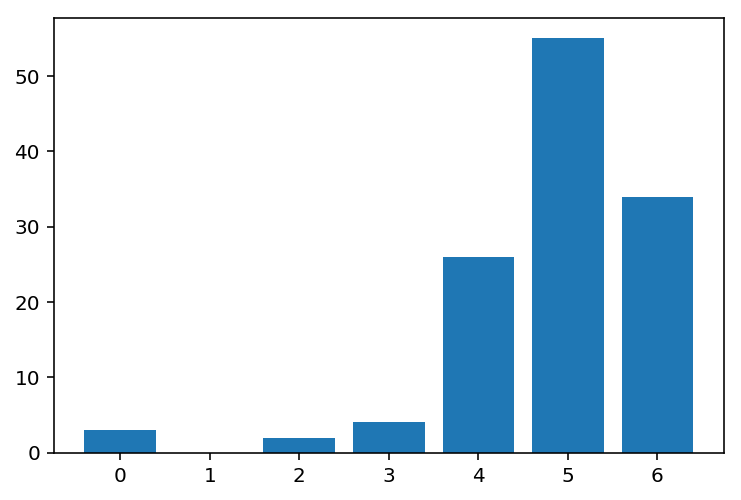

In [9]:
w = tally_by_weekday(hypermesh_commit_times)
plt.bar(range(7), w)
plt.show()

As you can see, I mostly work on the `hypermesh` repository in the weekend.

### Sampling repositories

We want to apply the above procedure to a sample of randomly selected GitHub repositories.
The following function selects a repository at random. The distribution is not precisely uniform, for two reasons:
- we uniformly select an index, but we return the first repo with index _at least_ this number; this means that repo's right after a long run of missing indices are more likely to be chosen
- we have a fixed maximal repository index, which does not precisely reflect the most recent state of GitHub; because the API makes it very difficult to discover the maximal index, we don't fix this

Nevertheless, we have every reason to expect that the sampling is good enough for our purposes, because it seems unlikely that there is a relationship between having many unused indices right before a repository, and this repository, say, committing only in the weekend.

In [10]:
# this gives a randomly selected repository from GitHub
# the sampling is *not* precisely uniform, but this is
# a reasonable enough approach given the complications
# of sampling exactly uniformly using the GitHub API
import random
def random_repo():
    max_repo_index = 107339029  # we won't sample repositories above this index
    while True:
        idx = random.randrange(1, max_repo_index + 1)
        link = 'https://api.github.com/repositories'
        headers = {'Authorization' : 'token ' + API_TOKEN}
        r = requests.get(link, headers=headers, params={'since' : str(idx)})
        if r.status_code is not 200:
            continue
        j = r.json()
        if len(j) > 0:
            return j[random.randrange(0, len(j))]

Here's a randomly selected repository:

In [11]:
random_repo()['full_name']

'ksprashu/openbank'

For our purposes, we will need a large number of repositories. Let's select 1000 of them. This will take a while.

**Note:** the code below is more naturally written as `repos = [random_repo() for i in range(1000)]`. However, if we then lose our network connection, the entire statement will fail, and we won't have any repositories. If we write the code with a loop, a timeout on a network connection breaks the loop, but we will still have all the repositories collected up to that point.

In [12]:
repos = []
for i in range(1000):
    repos.append(random_repo())
len(repos)

1000

Note that this took many API calls:

In [13]:
check_rate_limit()

Time until reset: 0:51:39.156364
1003/5000 used  (79.94% left)


Because fetching this data is not something we want to have to do again, we will store it using IPython's storemagic. That way, we can load the data from disk after restarting our session.

In [14]:
%store repos

Stored 'repos' (list)


### Fetching commit times

For each of these repositories, we now fetch the list of commit times. Again, this is heavy on the network, and we store the results.

In [15]:
times_all = []
for repo in repos:
    times_all.append(list_commit_times(repo['full_name']))
%store times_all

Stored 'times_all' (list)


Let's take a look at how many commits a typical repository has.

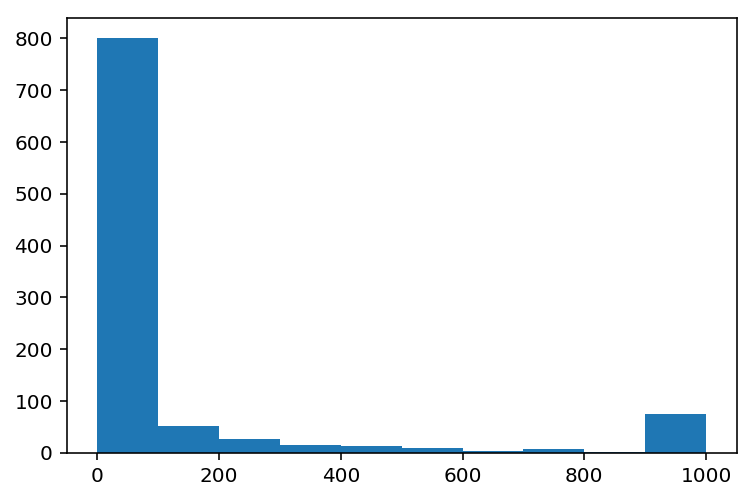

In [16]:
plt.hist([len(t) for t in times_all])
plt.show()

Note that there is a bump on the right because we listed at most 1000 commits for a given repository. All the repo's with more than 1000 commits show up as having 1000.
As you can see, most repositories have fewer than 100 commits. Let's zoom in a bit.

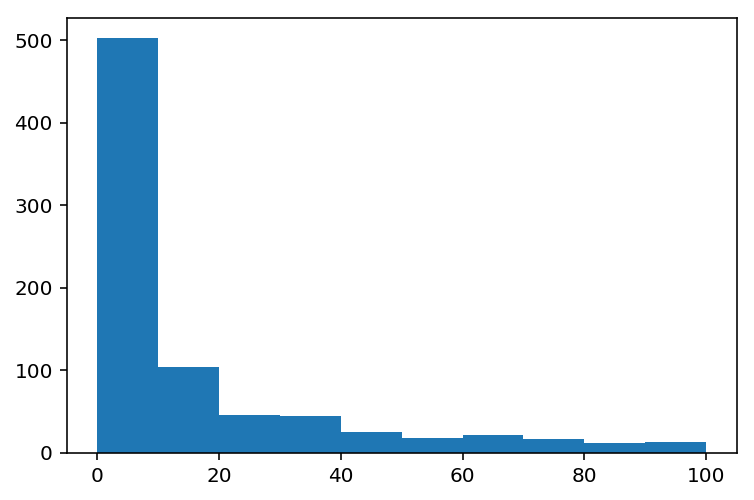

In [17]:
plt.hist([len(t) for t in times_all if len(t) <= 100])
plt.show()

We only want to take into account repositories that have a long enough history, to not have the results be influenced too much by created-but-never-done-anything-with-it repositories.
Let us filter out those repositories that have fewer than 10 commits.

In [18]:
times = [t for t in times_all if len(t) >= 10]
len(times)

498

## Performing the analysis

We now tally the commit times by weekday.

In [33]:
weekday_tallies = [tally_by_weekday(t) for t in times]
weekday_tallies[:6]

[[3, 6, 4, 3, 3, 0, 0],
 [30, 39, 17, 15, 17, 23, 0],
 [0, 0, 6, 4, 4, 0, 1],
 [3, 2, 2, 0, 1, 0, 2],
 [9, 10, 6, 3, 0, 13, 32],
 [0, 2, 2, 6, 1, 0, 0]]

We put these numbers in a matrix $Y$.

In [34]:
import numpy as np
Y = np.array(weekday_tallies, dtype='float64').T
Y -= Y.mean(axis=0)
Y /= np.linalg.norm(Y, axis=0, keepdims=True)
Y.shape

(7, 498)

We perform the principal component analysis by computing the singular value decomposition of our matrix.

In [35]:
u, s, v = np.linalg.svd(Y)

Let's take a look at the singular values:

In [36]:
s

array([  1.34617422e+01,   8.89352418e+00,   8.03845138e+00,
         7.75491416e+00,   7.68548018e+00,   7.33925909e+00,
         7.84402194e-15])

We see that the first two components explain some of the variance, but certainly not all of it.

Let's build the projection matrix that takes the first two principal components of an observation.

In [37]:
projection = v.T[:2]

We now project our observations. This gives us the optimal embedding of the days of the week into a plane, as measured by our test data.

In [38]:
R = projection @ Y.T; R

array([[-6.04717156, -1.34822447,  2.59621968,  0.78140774,  0.24450015,
         2.0658279 ,  1.70744056],
       [-0.64268331, -7.48998739, -2.4514688 , -0.35428397,  2.09505723,
         4.03832446,  4.80504177]])

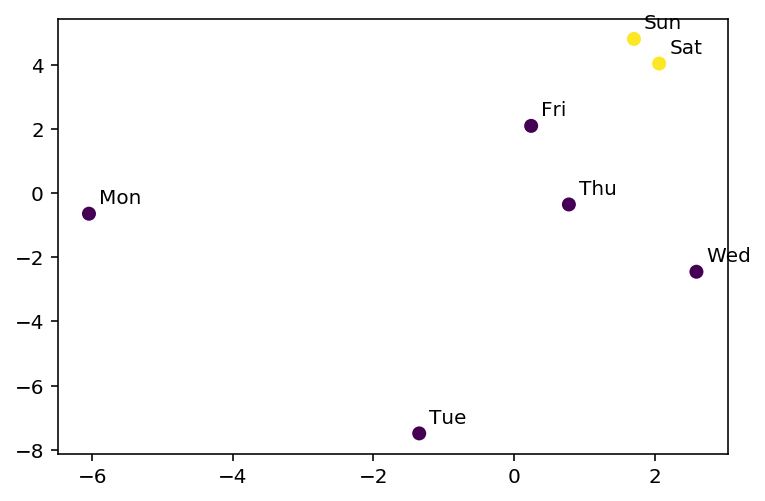

In [39]:
plt.scatter(R[0], R[1], c=[1,1,1,1,1,2,2])
for i, txt in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']):
    plt.annotate(txt, R[:,i], xytext=(5,5), textcoords='offset points')
plt.show()

Let's also plot just the first principal component (this is the same as projecting the above points to the horizontal axis).

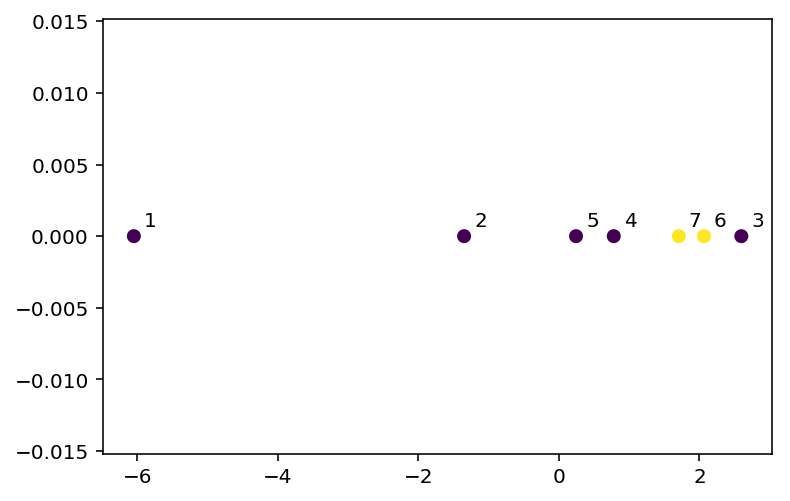

In [40]:
projection1 = v.T[:1]
S = projection1 @ Y.T
plt.scatter(S[0], [0 for x in S[0]], c=[1,1,1,1,1,2,2])
for i in range(7):
    plt.annotate(str(i+1), (S[0][i], 0), xytext=(5,5), textcoords='offset points')
plt.show()

**Observations.**
- We see that Monday seems to be the most special day, since it is embedded far away from the rest.
- Tuesday is also relatively isolated from the rest.
- Saturday and Sunday are relatively close together. It suggests that project with a lot of commits on Saturdays also have a lot of commits on Sundays, and vice versa. This makes sense, since one would expect to have weekend projects on GitHub, as well as professionally developed products that have most commits during business hours.
- Note that the days of the week are not merely embedded as a circle, like one might spontaneously try. There is more to weekdays on GitHub than merely their cyclic order.

### Bonus: drawing the loop

Just as an experiment, I would like to show you how you could connect the seven weekdays with an actual curve in the plane. This might be fun to see, since we think of weeks as cyclic.
We change the grouping for our tallies by increments of 15 minutes, and plot the principal components of the resulting tallies. I'll let you figure out the details.

In [41]:
Rs = []
for i in range(4*24):
    offset = datetime.timedelta(minutes = (i * 15))
    weekday_tallies = [tally_by_weekday(t, offset=offset) for t in times]
    Z = np.array(weekday_tallies, dtype='float64').T
    Z -= Z.mean(axis=0)
    Z /= np.linalg.norm(Z, axis=0, keepdims=True)
    R2 = projection @ Z.T
    Rs.append(R2)

In [42]:
x = [Rs[i][0][j] for j in range(7) for i in range(len(Rs))]
y = [Rs[i][1][j] for j in range(7) for i in range(len(Rs))]
x.append(x[0]) # close it up
y.append(y[0])

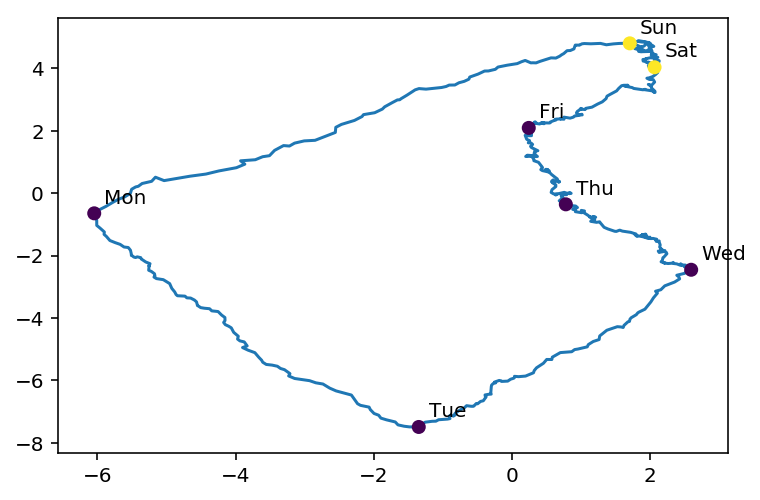

In [43]:
plt.plot(x, y)
plt.scatter(R[0], R[1], zorder=5, c=[1,1,1,1,1,2,2])
for i, txt in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']):
    plt.annotate(txt, R[:,i], xytext=(5,5), textcoords='offset points')
plt.show()

As you can see, the curve is still a bit jittery. We would probably get cleaner results by using more data, but we can't go much higher than 1000 before we run into the GitHub API's rate limiting.